In [1]:
import os
import scipy.io as spio
import numpy as np
import scipy.signal
from scipy.io import loadmat
import matplotlib.pyplot as plt
import math
import pywt
from scipy.optimize import least_squares

In [ ]:
## 读取数据
folder_path = '/home/wangqizheng/data3-14/data0.mat'
# folder_path = '../Resting/load_data.mat'
mat = spio.loadmat(folder_path, squeeze_me=True)
if "radar_i" in mat:
    radar_i = np.asarray(mat["radar_i"])
if "radar_q" in mat:
    radar_q = np.asarray(mat["radar_q"])
if "tfm_ecg1" in mat:
    tfm_ecg1 = np.asarray(mat["tfm_ecg1"])
if "tfm_ecg2" in mat:
    tfm_ecg2 = np.asarray(mat["tfm_ecg2"])

(8192,)


In [3]:
radar_i = radar_i[1]
radar_q = radar_q[1]
print(radar_i.shape)

()


In [28]:
## 降采样
radar_i = radar_i[::8]
radar_q = radar_q[::8]
print(radar_q.shape)

(262144,)


In [ ]:
## 使用DACM方法求解相位

phase1 = []
start_num = 0
dataLen = 8192
# tfm_ecg2 = tfm_ecg2[start_num:start_num+dataLen]
for i in range(start_num, start_num+dataLen):
    phase2 = 0
    for j in range(start_num+1, i):
        phase2 += radar_i[j+1]*(radar_q[j+1]-radar_q[j]) - radar_q[j+1]*(radar_i[j+1]-radar_i[j]) / (pow(radar_i[j+1], 2) + pow(radar_q[j+1], 2))
    phase1.append(phase2)

# 对相位进行二阶微分求加速度
c = []
for i in range(3, len(phase1) - 3):
    c1 = ((phase1[i-3]+phase1[i+3]) + 2 * (phase1[i-2]+phase1[i+2]) - (phase1[i-1]+phase1[i+1]) - 4 * phase1[i]) 
    c2 = 16 * (math.pow(1 / 2000, 2))
    c.append(c1/c2)

# x = np.arange(len(radar_i)/2000)
# diff2 = np.diff(phase1, n=2)

/tmp/ipykernel_8221/2013193441.py:12: RuntimeWarning: overflow encountered in scalar multiply
  phase2 += radar_i[j+1]*(radar_q[j+1]-radar_q[j]) - radar_q[j+1]*(radar_i[j+1]-radar_i[j]) / (pow(radar_i[j+1], 2) + pow(radar_q[j+1], 2))


In [6]:
# 四阶巴特沃斯带通滤波器，fs=2000，0.5 Hz to 20 Hz
# tfm_ecg2 = tfm_ecg2[start_num:start_num+dataLen]
resamplec = scipy.signal.resample_poly(c, 200, 2000)
b, a = scipy.signal.butter(4, [0.005, 0.2], 'band')
filtedData = scipy.signal.filtfilt(b, a, resamplec)

# resampleecg2 = scipy.signal.resample_poly(tfm_ecg2, 200, 2000)
print(len(filtedData))
# print(len(resampleecg2))
print(filtedData)

819
[-1.17244443e+08 -9.69168662e+07 -8.77801349e+07 -9.73741214e+07
 -1.26506813e+08 -1.67370961e+08 -2.04972650e+08 -2.22528489e+08
 -2.09093373e+08 -1.65866380e+08 -1.07548224e+08 -5.71555007e+07
 -3.62627209e+07 -5.57095279e+07 -1.11780239e+08 -1.89228763e+08
 -2.68207153e+08 -3.30945053e+08 -3.66395122e+08 -3.73471949e+08
 -3.62732466e+08 -3.53991311e+08 -3.68045736e+08 -4.15149772e+08
 -4.86460419e+08 -5.53681565e+08 -5.77872489e+08 -5.24184503e+08
 -3.76942881e+08 -1.49197267e+08  1.17564989e+08  3.64502991e+08
  5.33893807e+08  5.88121326e+08  5.21657915e+08  3.61134318e+08
  1.53604992e+08 -5.14929411e+07 -2.18349778e+08 -3.32142308e+08
 -3.96361513e+08 -4.23979929e+08 -4.28375374e+08 -4.18171518e+08
 -3.96706077e+08 -3.64333990e+08 -3.21274516e+08 -2.69616286e+08
 -2.14217602e+08 -1.62699170e+08 -1.24398152e+08 -1.07704300e+08
 -1.15716181e+08 -1.42045777e+08 -1.70394783e+08 -1.80673434e+08
 -1.60142033e+08 -1.13033717e+08 -6.10072706e+07 -3.21182261e+07
 -4.46107629e+07 -9.6

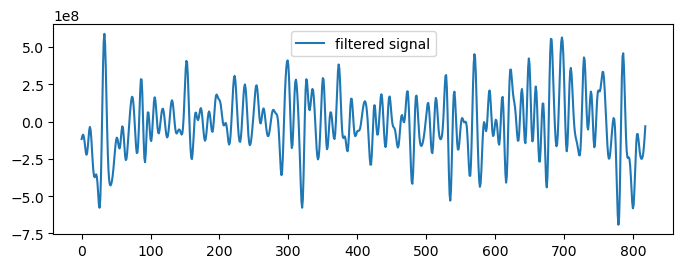

In [7]:

plt.figure(figsize=(8, 6))
plt.subplot(2,1,1)
plt.plot(filtedData, label='filtered signal')
plt.legend()
# plt.subplot(2,1,2) 
# plt.plot(resampleecg2, label='ECG signal')
# plt.legend()
plt.show()

In [26]:
# 指定 index 范围

start_index = 50
end_index = start_index+1024
j=9
i=1
extract_phase = {
        'phase': c
    }
phase_file_path = f'./train_data_12_13/phase/people{j}_phase.mat'  
spio.savemat(phase_file_path, extract_phase)  
print(f"Data saved to {phase_file_path}")
while end_index<4900:

    filtedDatasegment =filtedData[start_index:end_index]
    resampleecg2segment = resampleecg2[start_index:end_index]

    print(filtedDatasegment.shape)

    train_data = {
        'radar': filtedDatasegment,
        'ecg': resampleecg2segment
    }
    output_file_path = f'./train_data_12_13/people{j}_data{545 + i}.mat'  
    spio.savemat(output_file_path, train_data)  

    print(f"Data saved to {output_file_path}")
    i=i+1
    start_index = start_index+30
    end_index = start_index+1024


Data saved to ./train_data_12_13/phase/people9_phase.mat
(1024,)
Data saved to ./train_data_12_13/people9_data546.mat
(1024,)
Data saved to ./train_data_12_13/people9_data547.mat
(1024,)
Data saved to ./train_data_12_13/people9_data548.mat
(1024,)
Data saved to ./train_data_12_13/people9_data549.mat
(1024,)
Data saved to ./train_data_12_13/people9_data550.mat
(1024,)
Data saved to ./train_data_12_13/people9_data551.mat
(1024,)
Data saved to ./train_data_12_13/people9_data552.mat
(1024,)
Data saved to ./train_data_12_13/people9_data553.mat
(1024,)
Data saved to ./train_data_12_13/people9_data554.mat
(1024,)
Data saved to ./train_data_12_13/people9_data555.mat
(1024,)
Data saved to ./train_data_12_13/people9_data556.mat
(1024,)
Data saved to ./train_data_12_13/people9_data557.mat
(1024,)
Data saved to ./train_data_12_13/people9_data558.mat
(1024,)
Data saved to ./train_data_12_13/people9_data559.mat
(1024,)
Data saved to ./train_data_12_13/people9_data560.mat
(1024,)
Data saved to ./trai

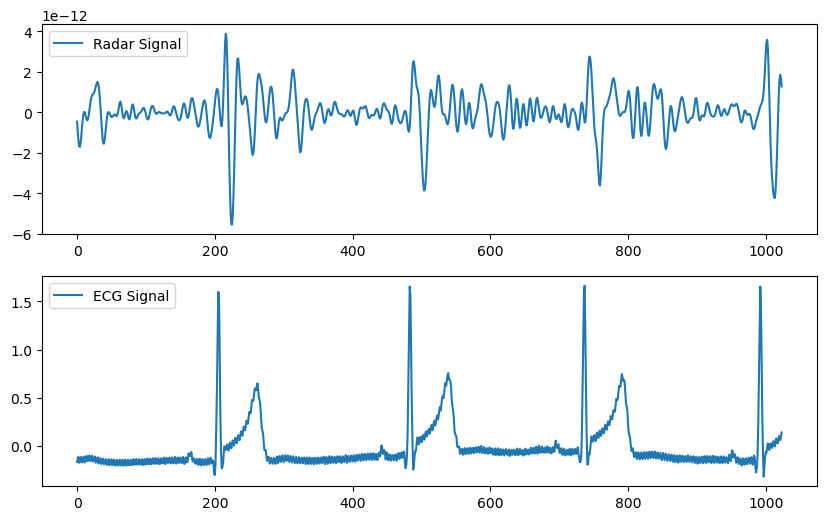

In [59]:
# 导入数据
data = spio.loadmat('./train_data/data1000.mat')

# 提取信号
radar_signal = data['radar'].flatten()
ecg_signal = data['ecg'].flatten()

# 绘制对比图像
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(radar_signal, label='Radar Signal')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(ecg_signal, label='ECG Signal')
plt.legend()
plt.show()